###  Modèle type LeNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_mendeley.csv',index_col=0)

In [3]:
src_img = '../images_detour/'

In [4]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [5]:
data.head()

,file_path,filename,class,size
0,../images_detour/BA_100102.jpg,BA_100102.jpg,basophil,363x360
1,../images_detour/BA_101381.jpg,BA_101381.jpg,basophil,363x360
2,../images_detour/BA_101611.jpg,BA_101611.jpg,basophil,363x360
3,../images_detour/BA_102039.jpg,BA_102039.jpg,basophil,363x360
4,../images_detour/BA_102750.jpg,BA_102750.jpg,basophil,363x360


In [6]:
data['class'].value_counts()

neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: class, dtype: int64

In [7]:
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans augmentation de données, charge seulement les images

In [8]:
def preprocess(x):
    img = x/255.
    return img

In [9]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [ ]:
data_generator.

In [10]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

C:\Users\LAURE\anaconda3\envs\Projet\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


Found 10935 validated image filenames belonging to 8 classes.
Found 2734 validated image filenames belonging to 8 classes.


C:\Users\LAURE\anaconda3\envs\Projet\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [11]:
# Création Callback pour stopper si stagnation et réduire learning rate
cb_early_stopping= EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)
cb_lr = ReduceLROnPlateau(monitor='val_loss',
                                         patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min')

In [12]:
# Création d'un modèle type LeNet
def model_LeNet():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=8,activation='softmax')) #8 Classes
    #Compilation
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = model_LeNet()

In [14]:
#Entrainement
history = model.fit(data_train_generator, epochs = 16, batch_size=32, validation_data = data_test_generator,callbacks=[cb_early_stopping,cb_lr])

Epoch 1/16
342/342 [==============================] - 615s 2s/step - loss: 0.8236 - accuracy: 0.6824 - val_loss: 0.4641 - val_accuracy: 0.8328
Epoch 2/16
342/342 [==============================] - 571s 2s/step - loss: 0.4017 - accuracy: 0.8547 - val_loss: 0.3883 - val_accuracy: 0.8639
Epoch 3/16
342/342 [==============================] - 625s 2s/step - loss: 0.2897 - accuracy: 0.8976 - val_loss: 0.3261 - val_accuracy: 0.8822
Epoch 4/16
342/342 [==============================] - 588s 2s/step - loss: 0.2059 - accuracy: 0.9257 - val_loss: 0.2844 - val_accuracy: 0.9023
Epoch 5/16
342/342 [==============================] - 558s 2s/step - loss: 0.1429 - accuracy: 0.9518 - val_loss: 0.5310 - val_accuracy: 0.8325
Epoch 6/16
342/342 [==============================] - 568s 2s/step - loss: 0.1169 - accuracy: 0.9599 - val_loss: 0.2897 - val_accuracy: 0.9049
Epoch 7/16
342/342 [==============================] - 750s 2s/step - loss: 0.0837 - accuracy: 0.9703 - val_loss: 0.4432 - val_accuracy: 0.8749

#### Prédiction sur les données d'évaluation

In [15]:
data_eval_generator = data_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)

Found 3416 validated image filenames belonging to 8 classes.


In [16]:
model.evaluate(data_eval_generator)

107/107 [==============================] - 43s 404ms/step - loss: 0.2996 - accuracy: 0.8961


[0.2996336817741394, 0.8960772752761841]

 * Score de 90%, +3% avec le détourage

In [17]:
#Prédiction
predict = model.predict(data_eval_generator)

In [18]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.81      0.90      0.85       222
  eosinophil       0.99      0.98      0.98       626
erythroblast       0.90      0.84      0.87       309
          ig       0.80      0.76      0.78       590
  lymphocyte       0.83      0.92      0.87       236
    monocyte       0.76      0.76      0.76       302
  neutrophil       0.95      0.96      0.95       682
    platelet       1.00      0.97      0.98       449

    accuracy                           0.90      3416
   macro avg       0.88      0.89      0.88      3416
weighted avg       0.90      0.90      0.90      3416



> Rappel plus faible sur les IG toujours, ainsi que les monocytes

In [20]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,200,4,0,8,6,3,1,0
eosinophil,4,616,1,2,0,1,2,0
erythroblast,0,0,260,15,24,3,5,2
ig,36,1,6,450,10,62,25,0
lymphocyte,2,0,4,9,218,3,0,0
monocyte,6,1,1,60,4,230,0,0
neutrophil,0,3,3,22,0,2,652,0
platelet,0,0,13,0,1,0,0,435


> Confusion importante IG/Monocyte et ig/basophil

In [21]:
model.save_weights("lenet_8_mendeley_detourage")


### GRAD CAM

In [22]:
import gradcam

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [24]:
img_size = (224, 224)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

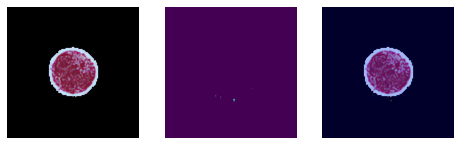

In [25]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path,(224,224), model, last_conv_layer_name,pred_index=0)

##### EOSINOPHIL

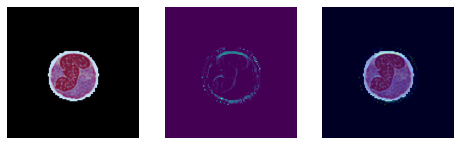

In [26]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=1)

##### ERYTHROBLAST

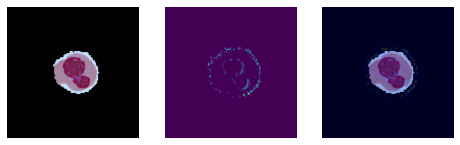

In [27]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=2)

##### IG

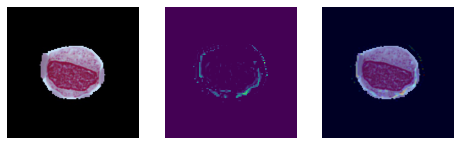

In [28]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

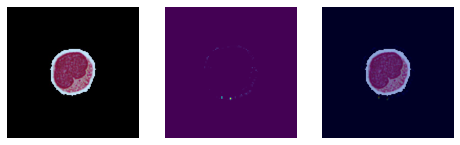

In [29]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

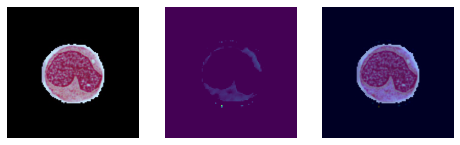

In [30]:
path = data[data['filename']=='MO_214087.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

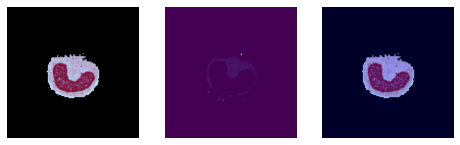

In [31]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=6)

##### PLATELET

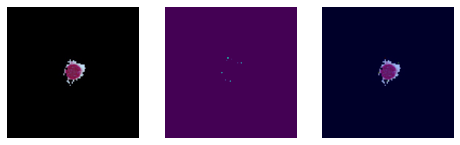

In [32]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=7)